In [1]:
!pip install pandas seaborn google-cloud-aiplatform tdqm google-generativeai
!gcloud auth application-default login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login&state=0GhjapelLiLMB2m8TwmTlmO5xK6XlS&access_type=offline&code_challenge=Zr1cP-byNes6WuZfCNijFoV9ixpfx86FN1BfpxZlLjc&code_challenge_method=S256


Credentials saved to file: [/Users/alistairkeiller/.config/gcloud/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).
Cannot find a quota project to add to ADC. You might receive a "quota exceeded" or "API not enabled" error. Run $ gcloud auth application-default set-quota-project to add a quota project.


In [1]:
import pandas as pd
import glob
import csv
import re
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
import google.generativeai as genai
import os
import time
from tqdm import tqdm
import base64
import vertexai
from vertexai.generative_models import GenerativeModel, Part, FinishReason
import vertexai.preview.generative_models as generative_models
from google.api_core.exceptions import InternalServerError, ResourceExhausted
import json
from tqdm.auto import tqdm
import re
tqdm.pandas()

In [3]:
vertexai.init(project="yolo-410704", location="us-central1")
gemini_pro_long = GenerativeModel("gemini-1.5-pro-preview-0409")

In [19]:
dfs = []


def read_file(file):
    try:
        return open(directory + file + ".txt", "r").read()
    except:
        return None


for info_file in glob.glob("RusLit/**/info.csv", recursive=True):
    try:
        directory = info_file[:-8]
        info = pd.read_csv(info_file)
        info["author"] = directory.split("/")[2]
        info["type"] = directory.split("/")[1]
        info["text"] = info["name"].map(read_file)
        dfs.append(info)
    except:
        pass

df = pd.concat(dfs, ignore_index=True).dropna()
df["year"] = (
    df["year"].astype(str).map(lambda x: x.split("-")[0].split(".")[0]).astype(int)
)

In [20]:
def clean_text(text):
    allowed_pattern = re.compile(r'[\u0041-\u005A\u0061-\u007A\u0410-\u044F\s`~\-_=+\[{\]}\\|;:\'",<.>/?]+')
    return ''.join(allowed_pattern.findall(text))

df["name"] = df["name"].apply(clean_text)
df["text"] = df["text"].apply(clean_text)

In [21]:
records = df[df["author"] == "Tolstoy"][["name", "text"]].to_dict(orient='records')
custom_dict = {record['name']: record['text'] for record in records}

with open('text.json', 'w') as file:
    json.dump(custom_dict, file)

In [44]:
retry_limit = 5


def get_genres(text, name):
    try:
        for attempt in range(retry_limit):
            try:
                return (
                    gemini_pro_long.generate_content(
                        text
                        + "Please provide a comma-separated list of single-word genres that best describe the text above: "
                    )
                    .candidates[0]
                    .content.parts[0]
                    .text
                )
            except ResourceExhausted:
                time.sleep(60)
    except InternalServerError:
        print(f"InternalServerError on {name} text")
    except IndexError:
        print(f"IndexError on {name} text")
    for attempt in range(retry_limit):
        try:
            return (
                gemini_pro_long.generate_content(
                    name
                    + "Please provide a comma-separated list of single-word genres that best describe the text above: "
                )
                .candidates[0]
                .content.parts[0]
                .text
            )
        except ResourceExhausted:
            time.sleep(60)
    print(f"failed on {name}")
    return None


try:
    df = pd.read_csv("gemini.csv")
except:
    df["genres"] = [
        get_genres(text, title)
        for text, title in tqdm(zip(df["text"], df["name"]), desc="Generating genres")
    ]
    df.drop("text", axis=1).to_csv("gemini.csv", index=False)

Generating genres: 2it [00:02,  1.27s/it]

IndexError on Скифы text


Generating genres: 6it [00:09,  1.43s/it]

InternalServerError on Борис Годунов text


Generating genres: 9it [01:20, 21.17s/it]

InternalServerError on Евгений Онегин text


Generating genres: 46it [05:35,  4.72s/it]

InternalServerError on Неделание text


Generating genres: 52it [06:47,  5.04s/it]

InternalServerError on Патриотизм и правительство text


Generating genres: 54it [07:51, 16.14s/it]

InternalServerError on Первая ступень text


Generating genres: 64it [09:07,  3.22s/it]

InternalServerError on Бедные люди text


Generating genres: 65it [09:19,  5.84s/it]

InternalServerError on Белые ночи text


Generating genres: 66it [10:23, 23.27s/it]

InternalServerError on Бесы text


Generating genres: 68it [10:52, 17.67s/it]

InternalServerError on Братья Карамазовы text


Generating genres: 69it [11:26, 22.58s/it]

InternalServerError on Вечный муж text


Generating genres: 70it [11:41, 20.30s/it]

InternalServerError on Господин Прохарчин text


Generating genres: 72it [11:45, 11.01s/it]

InternalServerError on Двойник text


Generating genres: 73it [12:59, 29.77s/it]

InternalServerError on Дневник писателя text


Generating genres: 75it [14:12, 30.02s/it]

InternalServerError on Дядюшкин сон text


Generating genres: 77it [14:25, 17.58s/it]

InternalServerError on Записки из подполья text


Generating genres: 80it [16:20, 28.09s/it]

InternalServerError on Короткая text


Generating genres: 81it [16:23, 20.66s/it]

InternalServerError on Крокодил text


Generating genres: 82it [16:26, 15.40s/it]

InternalServerError on Маленький герой text


Generating genres: 89it [18:16, 10.50s/it]

InternalServerError on Село Степанчиково и его обитатели text


Generating genres: 90it [18:31, 11.79s/it]

InternalServerError on Скверный анекдот text


Generating genres: 92it [19:38, 25.60s/it]

InternalServerError on Сон смешного человека text


Generating genres: 96it [20:24, 13.87s/it]

IndexError on Чужая жена и муж под кроватью text


Generating genres: 107it [22:41, 15.85s/it]

InternalServerError on Барыня text


Generating genres: 127it [25:11,  2.04s/it]

IndexError on Вишнёвый сад text


Generating genres: 156it [29:52, 15.67s/it]

IndexError on Дуэль text


Generating genres: 158it [29:55,  8.37s/it]

InternalServerError on Ионыч text


Generating genres: 164it [31:05,  5.26s/it]

InternalServerError on Палата №6 text


Generating genres: 169it [31:13,  2.04s/it]

InternalServerError on Три сестры text


Generating genres: 173it [32:41, 10.06s/it]

InternalServerError on Доктор Крупов text


Generating genres: 174it [32:44,  7.91s/it]

InternalServerError on Долг прежде всего text


Generating genres: 175it [33:54, 26.33s/it]

InternalServerError on Елена text


Generating genres: 177it [34:11, 17.74s/it]

InternalServerError on Легенда text


Generating genres: 179it [34:18, 10.64s/it]

InternalServerError on С того берега text


Generating genres: 180it [34:31, 11.39s/it]

InternalServerError on Скуки ради text


Generating genres: 184it [35:53, 14.12s/it]

InternalServerError on Вий text


Generating genres: 185it [35:56, 10.88s/it]

InternalServerError on Записки сумасшедшего text


Generating genres: 194it [37:34,  4.70s/it]

InternalServerError on Ревизор text


Generating genres: 196it [38:51, 18.60s/it]

InternalServerError on Старосветские помещики text


Generating genres: 197it [38:53, 13.83s/it]

InternalServerError on Тарас Бульба text


Generating genres: 198it [39:05, 13.27s/it]

InternalServerError on Шинель text


Generating genres: 200it [39:10,  7.62s/it]

InternalServerError on Герой нашего времени text


Generating genres: 203it [40:41, 21.11s/it]

IndexError on В людях text


Generating genres: 209it [41:53, 12.85s/it]

IndexError on Детство text


Generating genres: 213it [43:02, 17.48s/it]

InternalServerError on Ледоход text


Generating genres: 216it [43:07,  7.16s/it]

IndexError on Мать text


Generating genres: 217it [44:11, 24.00s/it]

InternalServerError on Мещане text


Generating genres: 219it [44:41, 20.05s/it]

InternalServerError on На дне text


Generating genres: 221it [45:02, 14.41s/it]

InternalServerError on Несвоевременные мысли text


Generating genres: 222it [45:14, 13.65s/it]

InternalServerError on Озорник text


Generating genres: 225it [46:19, 18.24s/it]

InternalServerError on Проходимец text


Generating genres: 227it [46:23,  9.99s/it]

InternalServerError on Сказки об Италии text


Generating genres: 232it [48:03, 14.31s/it]

InternalServerError on Челкаш text


Generating genres: 237it [48:13,  3.99s/it]

IndexError on Анна Каренина text


Generating genres: 238it [49:20, 22.91s/it]

InternalServerError on Божеское и человеческое text


Generating genres: 239it [49:23, 17.00s/it]

IndexError on Война и мир. Том 1 text


Generating genres: 240it [49:26, 12.87s/it]

InternalServerError on Война и мир. Том 2 text


Generating genres: 241it [50:47, 33.23s/it]

InternalServerError on Война и мир. Том 3 text


Generating genres: 243it [51:49, 30.92s/it]

InternalServerError on Воскресение text


Generating genres: 244it [52:10, 28.19s/it]

InternalServerError on Два гусара text


Generating genres: 246it [52:23, 16.63s/it]

InternalServerError on Детство text


Generating genres: 254it [54:58, 25.57s/it]

InternalServerError on Крейцерова соната text


Generating genres: 255it [55:07, 20.61s/it]

InternalServerError on Метель text


Generating genres: 256it [55:11, 15.49s/it]

InternalServerError on Набег text


Generating genres: 262it [56:29,  8.24s/it]

InternalServerError on Разжалованный text


Generating genres: 264it [57:34, 17.99s/it]

InternalServerError on Севастополь в августе 1855 года text


Generating genres: 270it [59:01, 14.31s/it]

InternalServerError on Утро пемещика text


Generating genres: 272it [59:16, 11.12s/it]

InternalServerError on Хозяин и работник text


Generating genres: 273it [1:00:25, 28.60s/it]

InternalServerError on Холстомер text


Generating genres: 276it [1:00:57, 16.32s/it]

InternalServerError on Ася text


Generating genres: 278it [1:01:12, 12.23s/it]

InternalServerError on Дворянское гнездо text


Generating genres: 279it [1:01:43, 18.01s/it]

InternalServerError on Дым text


Generating genres: 281it [1:03:32, 33.42s/it]

InternalServerError on Муму text


Generating genres: 282it [1:03:35, 24.33s/it]

InternalServerError on Отцы и дети text


Generating genres: 285it [1:04:30, 18.27s/it]

InternalServerError on Яков Пасынков text


Generating genres: 292it [1:05:53,  6.58s/it]

InternalServerError on Гора Звезды text


Generating genres: 293it [1:06:06,  8.56s/it]

InternalServerError on Декадент text


Generating genres: 301it [1:08:34, 18.82s/it]

InternalServerError on Огненный ангел text


Generating genres: 308it [1:10:00, 21.72s/it]

InternalServerError on Рея Сильвия text


Generating genres: 314it [1:10:13,  4.09s/it]

InternalServerError on Юпитер поверженный text


Generating genres: 320it [1:12:02,  7.05s/it]

InternalServerError on Дубровский text


Generating genres: 322it [1:13:13, 18.47s/it]

InternalServerError on История Пугачёва text


Generating genres: 326it [1:14:40, 21.42s/it]

InternalServerError on Пиковая дама text


Generating genres: 329it [1:14:52, 13.66s/it]
/var/folders/k6/ysy9mpp90lq6zhz2s2qvv23r0000gn/T/ipykernel_5097/653861570.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["genres"] = [


In [45]:
df = df.dropna()
df["genres"] = df["genres"].map(lambda x: x.strip().lower().split(", "))

In [46]:
df_explode = df.explode("genres")
df_explode = df_explode[df_explode["genres"] != ""]
genre_trends = df_explode.groupby(["year", "genres"]).size().unstack(fill_value=0)
filtered_genre_trends = genre_trends[genre_trends.sum().sort_values()[-10:].index]
percentage_filtered_genre_trends = (
    filtered_genre_trends.divide(filtered_genre_trends.sum(axis=1), axis=0) * 100
)
percentage_filtered_genre_trends.dropna()
percentage_filtered_genre_trends = percentage_filtered_genre_trends.reset_index()
melted_percentage_filtered_genre_trends = percentage_filtered_genre_trends.melt(
    id_vars="year", var_name="genre", value_name="popularity"
)

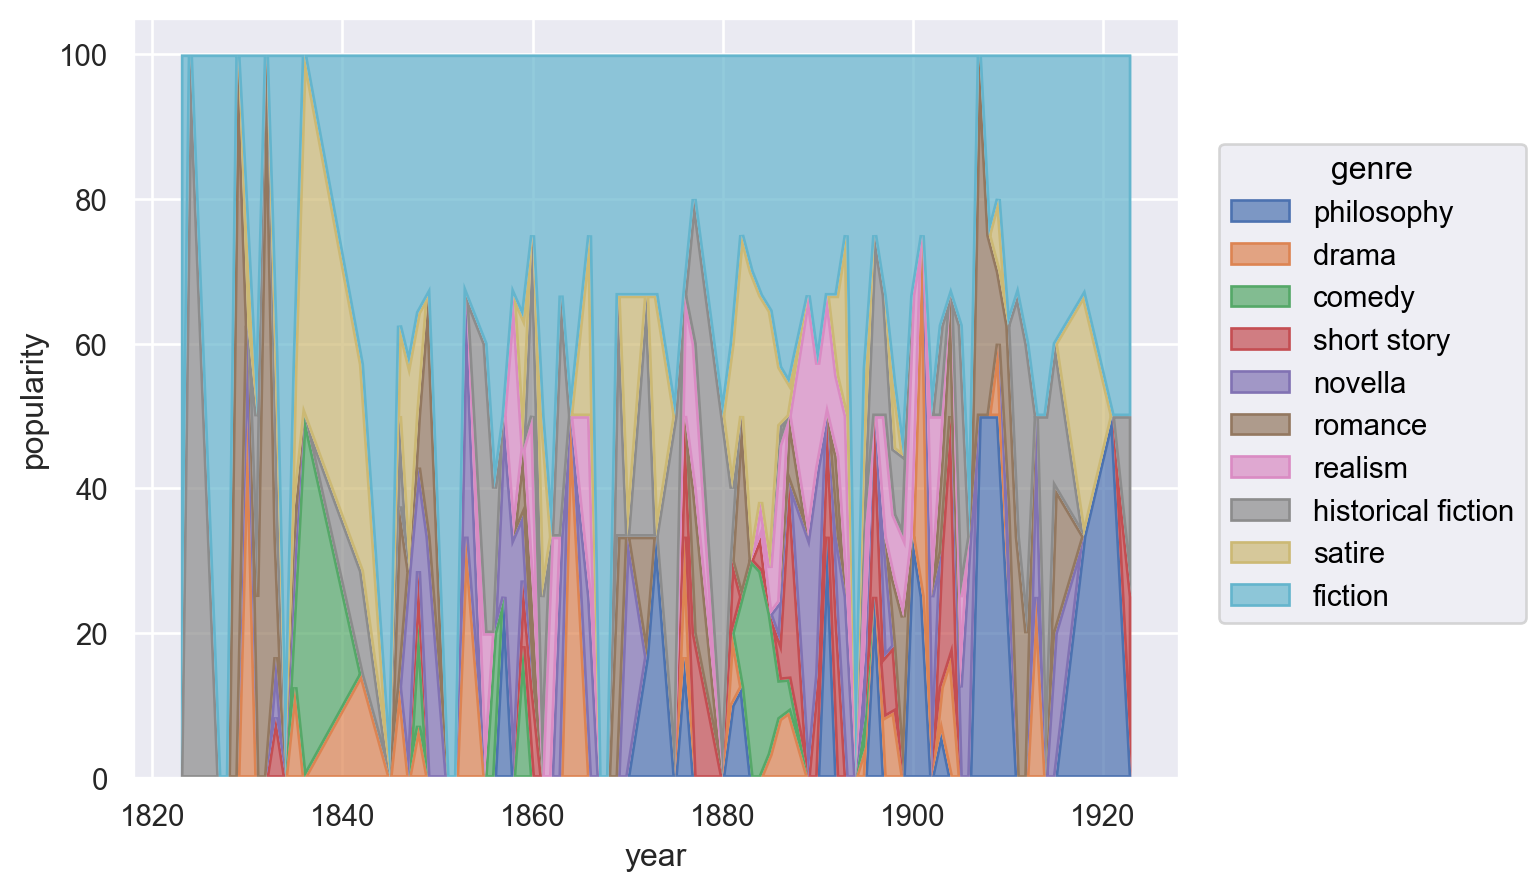

In [47]:
so.Plot(
    melted_percentage_filtered_genre_trends, "year", "popularity", color="genre"
).add(so.Area(alpha=0.7), so.Stack())

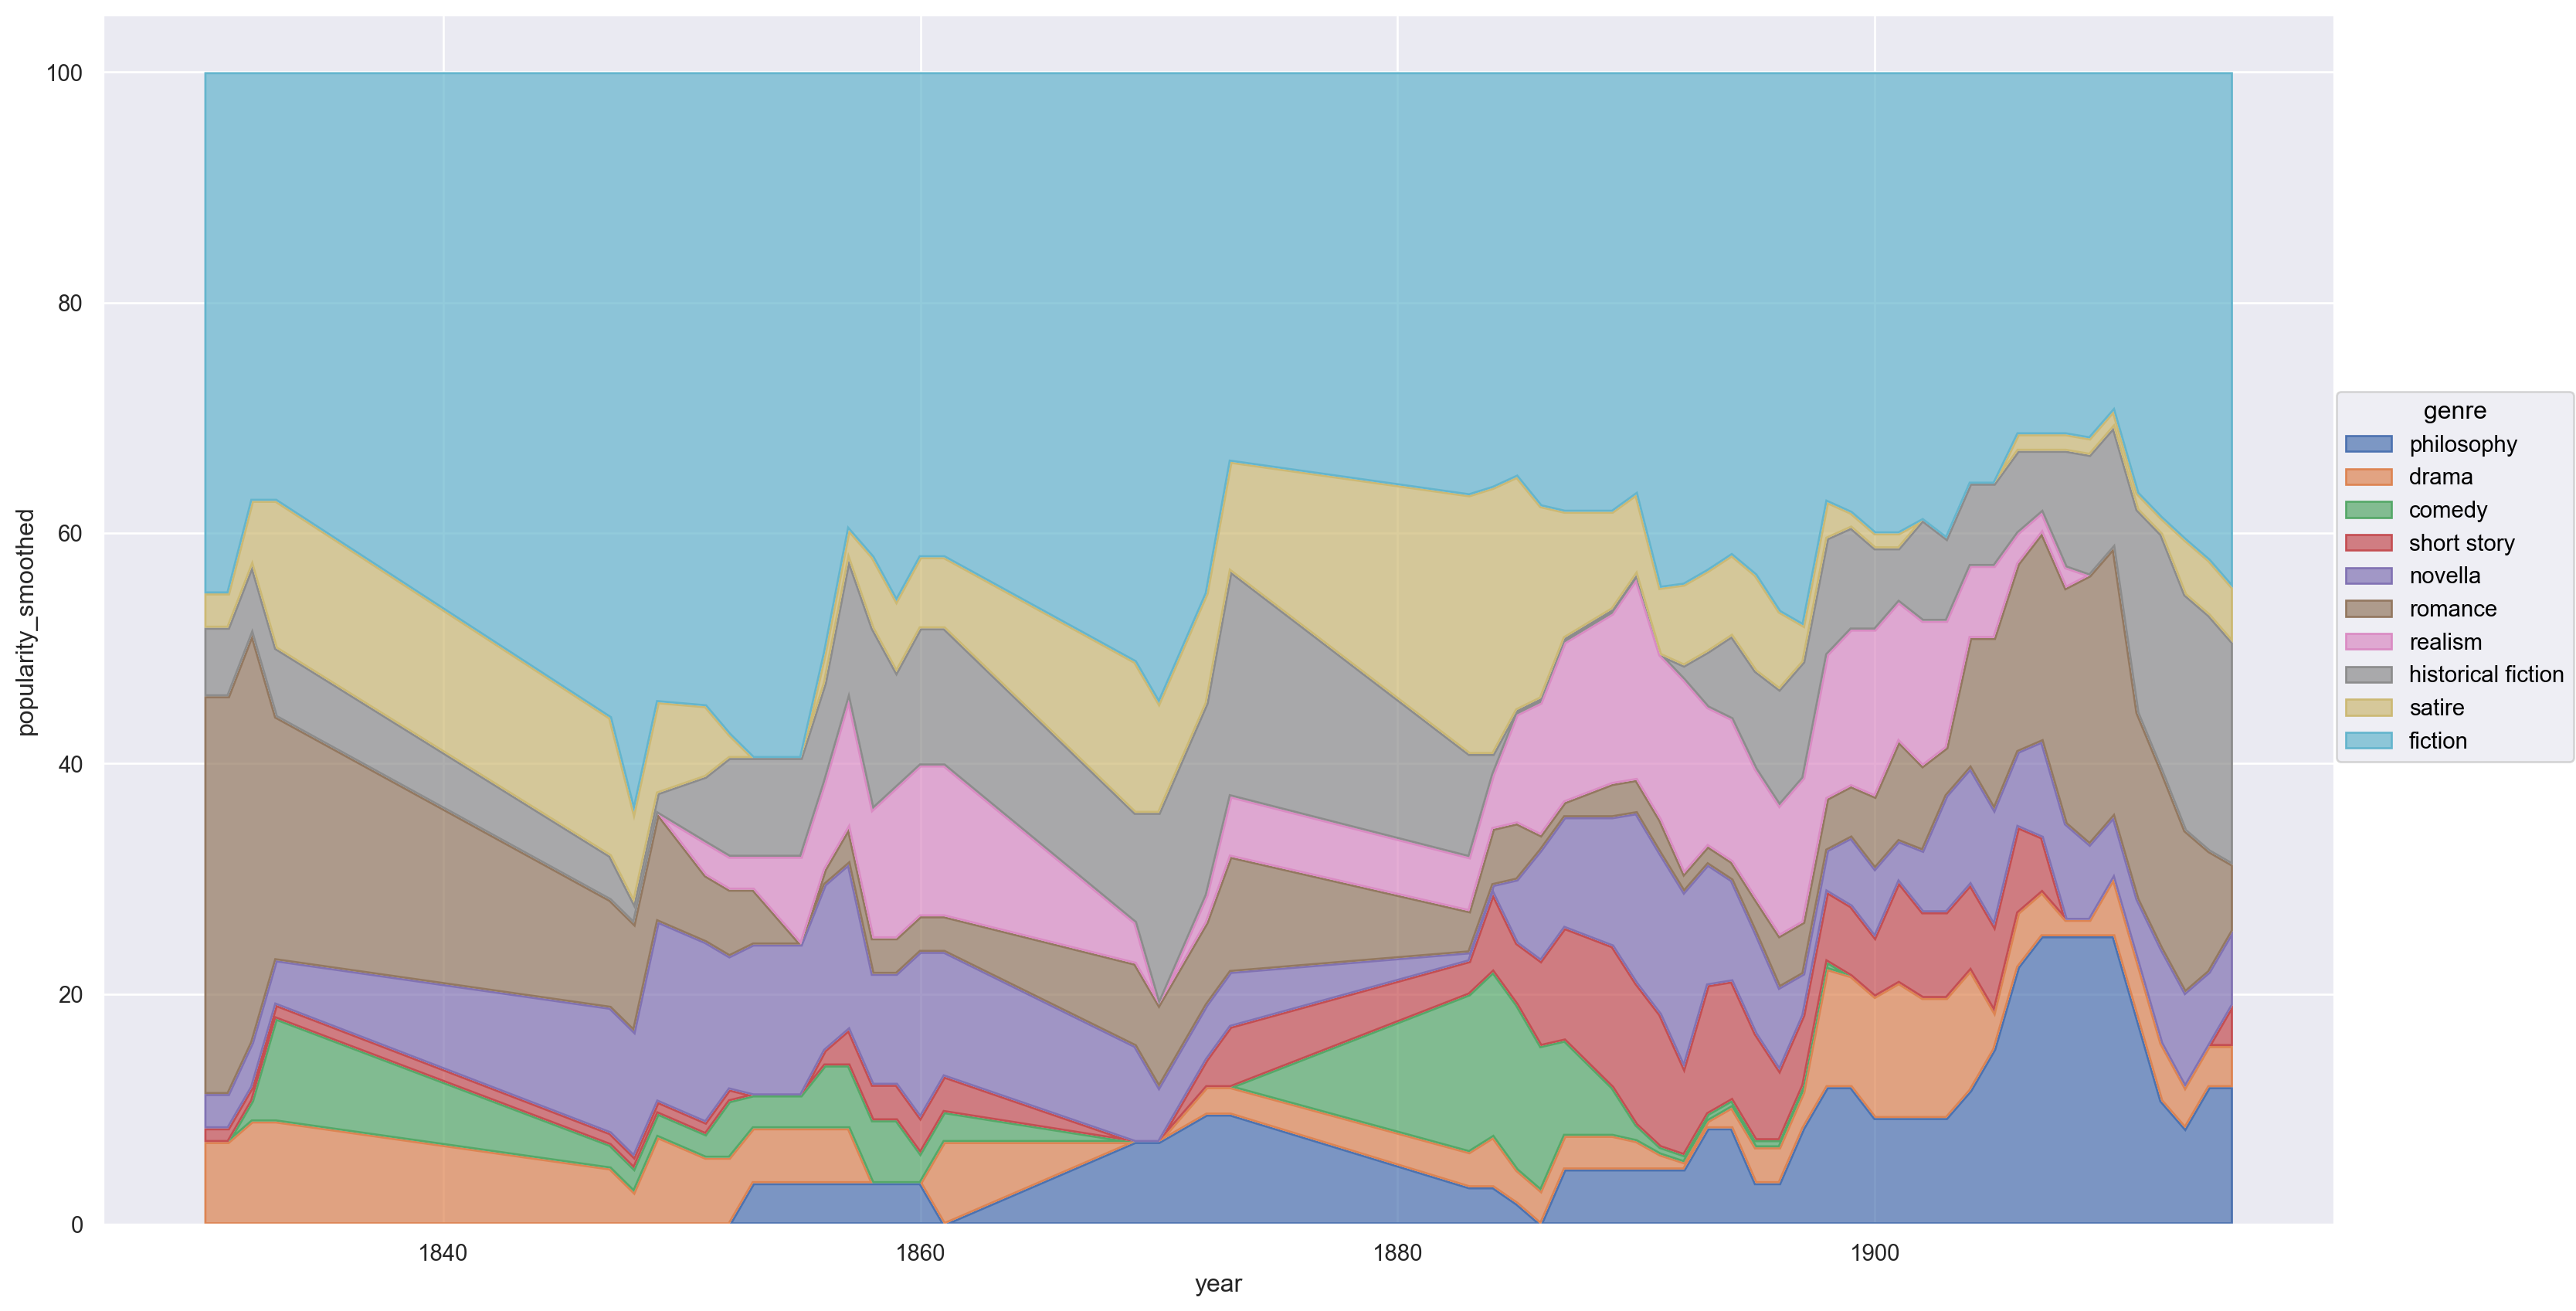

In [48]:
window_size = 7

melted_percentage_filtered_genre_trends["popularity_smoothed"] = (
    melted_percentage_filtered_genre_trends.groupby("genre")["popularity"].transform(
        lambda x: x.rolling(window=window_size, center=True).mean()
    )
)

so.Plot(
    melted_percentage_filtered_genre_trends,
    "year",
    "popularity_smoothed",
    color="genre",
).add(so.Area(alpha=0.7), so.Stack()).layout(size=(16, 9)).save(
    "gemini.png", bbox_inches="tight"
)

In [ ]:
# gemini_pro_long.generate_content(
#     "\"The play portrays the visit of an elderly professor and his glamorous, much younger second wife, Yelena, to the rural estate that supports their urban lifestyle. Two friends—Vanya, brother of the professor's late first wife, who has long managed the estate, and Astrov, the local doctor—both fall under Yelena's spell while bemoaning the ennui of their provincial existence. Sonya, the professor's daughter by his first wife, who has worked with Vanya to keep the estate going, suffers from her unrequited feelings for Astrov. Matters are brought to a crisis when the professor announces his intention to sell the estate, Vanya and Sonya's home, with a view to investing the proceeds to achieve a higher income for himself and his wife.\"\nRepeat each sentance with a catigorization after: horror short story humor social commentary satire fiction historical tragedy romance drama"
# ).candidates[0].content.parts[0].text

In [ ]:
# gemini_pro_long.generate_content(
#     "\"The play portrays the visit of an elderly professor and his glamorous, much younger second wife, Yelena, to the rural estate that supports their urban lifestyle. Two friends—Vanya, brother of the professor's late first wife, who has long managed the estate, and Astrov, the local doctor—both fall under Yelena's spell while bemoaning the ennui of their provincial existence. Sonya, the professor's daughter by his first wife, who has worked with Vanya to keep the estate going, suffers from her unrequited feelings for Astrov. Matters are brought to a crisis when the professor announces his intention to sell the estate, Vanya and Sonya's home, with a view to investing the proceeds to achieve a higher income for himself and his wife.\"\nRewrite the abstract like Uncle Vanya was a political commentary satire of Russia in 1870:"
# ).candidates[0].content.parts[0].text